# Tutorial 3 - A Feedforward Spiking Neural Network

## Learn hot to
- simplify the LIF neuron to make it deep learning-friendly
- implement a feedforward SNN

> 실제 딥러닝에 적용하기 위해 LIF 뉴런 모델을 간소화하는 것과, 순전파 SNN을 구현해본다.

---

# 1. Simplifying the LIF neuron model

## 1.1 Decay rate: $\beta$

이전 튜토리얼에서 다뤘던 passive membrane 모델은 다음과 같다.

> $\tau\frac{dU(t)}{dt}=-U(t)+I_{in}(t)R\ \ \ (\tau=RC)$
> 
> 해당 식을 **discontinous**하게 변형하면
>
> $\tau\frac{U(t+\Delta t)-U(t)}{\Delta t}=-U(t)+I_{in}(t)R$
>
> $U(t+\Delta t)=(1-\frac{\Delta t}{\tau})U(t)+\frac{\Delta t}{\tau}I_{in}(t)R$

위 식에서 인풋 전류가 없다고 가정하여, $I_{in}(t)=0A$ 라 하면 아래와 같이 $U(t)$ 에 대한 텀만 남는다.

> $U(t+\Delta t)=(1-\frac{\Delta t}{\tau})U(t)$

그럼 시간 변화 $\Delta t$ 에 대해서 membrane potential $U(t)$ 의 변화율을 알 수 있는데 이를 다음과 같이 $\beta$ 로 정의하고자 한다. $\beta$ 는 decay rate(붕괴율, 붕괴비)라 한다. 시간 변화에 따라 추가적인 인풋 신호가 들어오지 않는다면, $\beta$ 에 비례하며 출력 신호가 줄어든다.

> $\beta=(1-\frac{\Delta t}{\tau})$

## 1.2 Weighted input current

이제 membrane potential이 순간적인 인풋 전류에 의해 발생한다고 가정하고, 위에서 정리한 $\beta$ 를 사용하여, 위 식을 이산 시간($\Delta t=1$)에 대해 정의하면 아래와 같이 표현할 수 있다. 동시에 식의 간소화를 위해 $R=1$ 을 가정한다.

> $U[t+1]=\beta U[t]+(1-\beta)I_{in}[t+1]$

이 식을 딥러닝의 관점으로 표현하면, $I_{in}(t)$ 는 네트워크의 입력인 $X$ 가 될 것이고, $(1-\beta)$ 는 학습 가능한 가중치, $W$ 로 볼 수 있을 것이다.

> $U[t+1]=\beta U[t]+WX[t+1]$

이후 학습을 진행할 때, $W$ 는 $\beta$ 에 독립적으로 업데이트 되는 학습 가능한 파라미터이고, $\beta$ 는 하이퍼 파라미터로 취급한다.

## 1.3 Spiking and Reset

한 뉴런에 대해서 입력 신호(membrane)가 특정 임계치를 넘기면 해당 뉴런이 활성화되고 출력 신호(spike)를 생성한다. 그리고 뉴런이 활성화 된 이후에는 다시 리셋 되어 이후의 신호에 대해 입력받을 상태가 되야한다. 이를 위해 위 식에 뉴런의 리셋 텀을 추가해준다.

> $U[t+1]=\underbrace{\beta U[t]}_{decay}+\underbrace{WX[t+1]}_{input}-\underbrace{S[t]U_{thr}}_{reset}$

여기서 마지막 리셋 텀의 함수 $S[t]$ 는 아래와 같이 뉴런이 활성되었을 때는 1, 아닌 경우에는 0을 출력하는 이진 함수이다. 해당 텀을 활용하여 이전 time-step에서 뉴런이 활성화되었다면, 현재 출력에 대해서는 threshold 만큼의 값을 감하여 이전 신호의 영향으로부터 현재 뉴런을 초기화하는 것과 같은 효과를 기대할 수 있게된다.

> $S[t]=\left\{\begin{matrix} 1,\ if U(t) > U_{thr} \\ 0,\ \ \ \ \ \ \ otherwise \end{matrix}\right.$


## 1.4 Code implementation

위와 같이 정리된 LIF 모델을 함수로 구현하여, 인풋을 가했을 때 출력을 다음과 같이 확인할 수 있다.

In [1]:
import snntorch as snn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from snntorch import spikeplot as splt
from snntorch import spikegen

In [2]:
def LeakyIntegrate_and_Fire(prev_mem, x, w, beta, threshold=1):
    # prev_mem : previous membrane output
    # x        : current input signal
    # w        : weight for current input
    # beta     : decay rate
    # threshold: neuron threshold for spike output
    
    spk = (prev_mem > threshold)     # If membrane exceeds threshold, spk = 1, else = 0
    mem = beta * prev_mem + w*x - spk*threshold
    return spk, mem

### 1.4.1 하이퍼 파라미터 $\beta$

Membrane potential은 $\tau\frac{dU(t)}{dt}=-U(t)+I_{in}(t)R$ 식으로 정의되고, 이전 튜토리얼에서는 이 식을 다음과 같이 변형할 수 있었다.

> $U(t)=I_{in}(t)R+(U_0-I_{in}(t))e^{-\frac{t}{\tau}}$

그리고 1.1 에서는 $\beta$ 를 인풋 신호가 없을 때($I_{in}(t)=0$), 연속된 time-step 에서의 membrane potential 간의 비로 정의했었다.

이제 바로 위 식에서 인풋 신호가 없을 때($I_{in}(t)=0$)를 가정하여 모든 $I_{in}(t)$ 에 0을 대입하면, 연속 시간에서 membrane potential은 다음과 같다.

> $U(t)=U_0e^{-\frac{t}{\tau}}$
>
> $U(t+\Delta t)=U_0e^{-\frac{t+\Delta t}{\tau}}$

이전 출력에 대한 현재 출력의 비가 $\beta$ 이므로

> $\beta=\frac{U(t+\Delta t)}{U(t)}=\frac{U_0e^{-\frac{t+\Delta t}{\tau}}}{U_0e^{-\frac{t}{\tau}}}=e^{-\frac{\Delta t}{\tau}}$

이렇게 $\beta$ 를 정의하는 것이 연속시간에서의 정의이기 때문에 더욱 정확한 값이라고 할 수 있겠다. $\Delta t, \tau$ 두 상수를 정해줌으로써 $\beta$ 를 구할 수 있다. 그리고 $\beta$ 를 정의 하는 두 식 사이의 오차($\beta=1-\frac{\Delta t}{\tau}=e^{-\frac{\Delta t}{\tau}}$)는 $\Delta t << \tau$ 일 수록 줄어든다.

In [3]:
# Set neuronal params
delta_t = torch.tensor(1e-3)
tau     = torch.tensor(5e-3)
beta    = torch.exp(-delta_t/tau)

print(f'The decay rate is: {beta:.3f}')
print(f'for error comparison, beta: {1-delta_t/tau:.3f}')

The decay rate is: 0.819
for error comparison, beta: 0.800


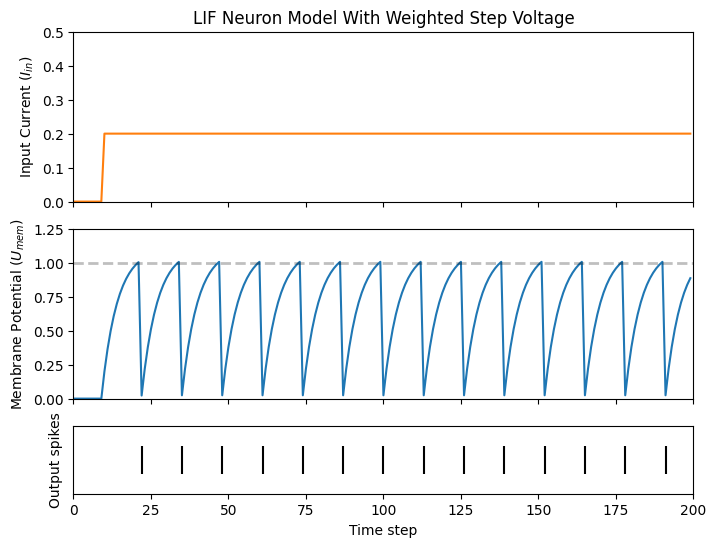

In [4]:
num_steps = 200

#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

# Initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), dim=0)    # torch.cat: concatenate
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# Neuron params
w = 0.4
beta = 0.819

# Neuron simulation
for step in range(num_steps):
    spk, mem = LeakyIntegrate_and_Fire(mem, x[step], w=w, beta=beta)
    mem_rec.append(mem)
    spk_rec.append(spk)
    
# Convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

# 2 Leaky neuron model in snnTorch

위에서 구현한 것과 같은 1차 LIF 모델은 snnTorch의 *snn.Leaky* 함수로 구현되어 있다.

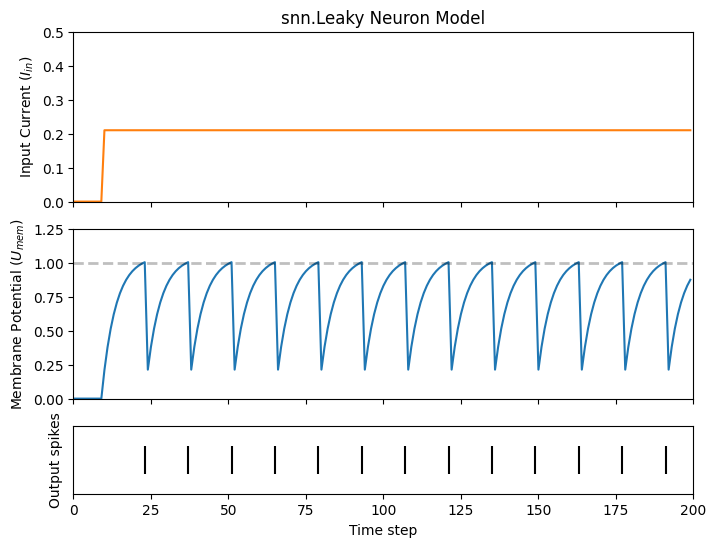

In [5]:
lif1 = snn.Leaky(beta=0.8)

# Small step current input
w = 0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), dim=0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# Neuron simulation
for step in range(num_steps):
    spk, mem = lif1(cur_in[step], mem)
    mem_rec.append(mem)
    spk_rec.append(spk)
    
# Convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

# 3 A Feedforward SNN

위에서는 단일 뉴런이 입력에 대해 어떻게 반응하는지를 알아봤다. 여기서는 3-layer SNN을 구현해본다.

![28](./images/2_8_fcn.png)

먼저 네트워크의 구조를 정의하면, spiking 뉴런들의 hidden variable과 출력 값을 초기화해야 한다. 이 과정은 내부 함수인 *init_\*()* 를 통해 수행할 수 있다.

In [6]:
# Layer params
num_inputs  = 784       # 28*28
num_hidden  = 1000
num_outputs = 10        # num of N-MNIST labels
beta        = 0.99

# Initialize layers
fc1  = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2  = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

In [7]:
# Inintialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif1.init_leaky()

# Record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

이제 정의된 SNN을 통과하기 위한 입력 데이터를 준비한다. 입력 데이터 형태는 다음과 같이 정의된다.

> $[time\times batch\_size \times feature\_dimensions]$

N-MNIST 데이터셋을 가정했을 때, $feature\_dimensions$ 은 $28\times 28=784$ 이다. 그리고 한 이미지에 대해 200번의 time-step을 가정하여 $time$ 을 200으로 정의한다. 마지막으로 실제 학습에서는 $batch\_size$ 를 정의해야 하지만, 여기서는 단순히 어떤식으로 feadforward 되는지를 보기 위하여 $200\times 1\times 784$ 크기의 입력을 준비한다.

In [8]:
spk_in = spikegen.rate_conv(torch.rand((200,784))).unsqueeze(1)     # unsqueeze: Add dimension at index
print(f'Dimension of spk_in: {spk_in.size()}')

Dimension of spk_in: torch.Size([200, 1, 784])


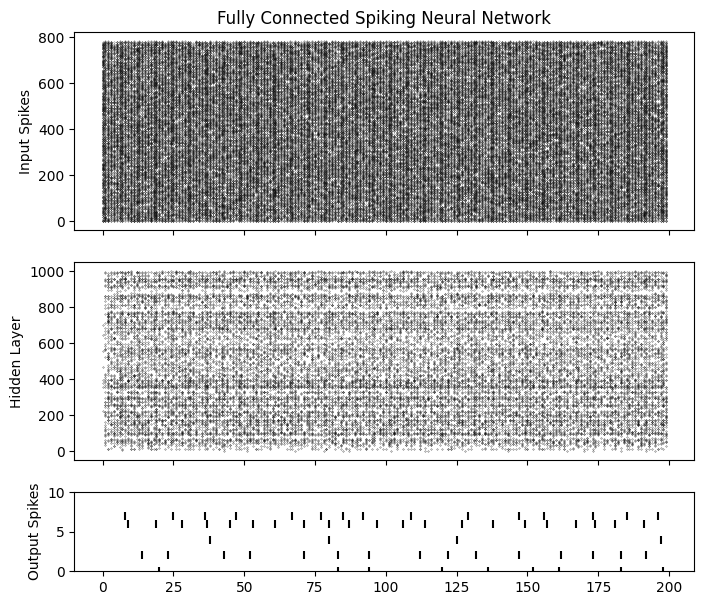

In [9]:
# Network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step])        # Post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1)   # mem[t+1] <-- post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)
    
    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)
    
# Convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

위 결과는 랜덤한 입력을 네트워크에 통과시켰기 때문에 의미가 있는 것은 아니다. 다만 네트워크가 어떻게 입력에 대해 출력을 생성하는지를 확이할 수 있었다.

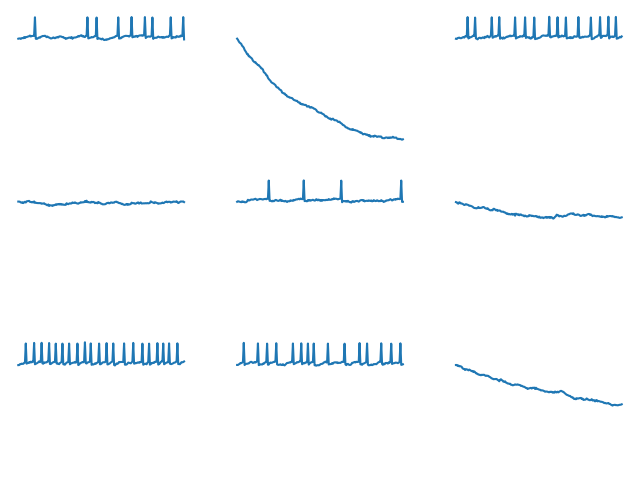

In [10]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf()
fig.set_size_inches(8, 6)